In [69]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import time
import wandb
import pytorch_lightning as pl

import FunctionCollection as fc
import importlib
fc = importlib.reload(fc)
import os

In [70]:
path = r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning'

run_name = 'oscNext_angle_m9'

args = {'N_edge_feats': 6,
        'N_dom_feats': 5,
        'N_targets': 2,
        'N_outputs': 4,
        'N_metalayers': 1,
        'N_hcs': 64,
        'diagonal_cov': True,
        'wandb_activated': True,
        'type': 'twice_Polar_NLLH',
        'zenith': True,
        'id': wandb.util.generate_id()[:4],
        'eps': 0,
        'lr': 0.0209,
        'filename': 'dev_level7_mu_e_tau_oscweight_000_unscaled.db',#dev_level7_mu_e_tau_oscweight_000.db #rasmus_classification_muon_3neutrino_3mio.db #dev_level7_oscNext_IC86_003.db
        'features': 'charge_log10, dom_time, dom_x, dom_y, dom_z',
        'targets': 'azimuth, zenith',
        'TrTV': (0.025,0.995,1)
       }

In [71]:
tf = pd.read_pickle(r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\datasets\transformers.pkl')
time_center, time_scale = tf['features']['time'].center_[0], tf['features']['time'].scale_[0]
charge_center, charge_scale = tf['features']['charge_log10'].center_[0], tf['features']['charge_log10'].scale_[0]
charge_center

-0.033858261664001306

In [75]:
filepath = os.path.join(path,'raw_data/dev_level7_mu_e_tau_oscweight_000/data')
# tf = pd.read_pickle(r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\datasets\transformers.pkl')
# tf = pd.read_pickle(r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\raw_data\dev_level7_mu_e_tau_oscweight_000\data\meta\transformers.pkl')
# event_nos = pd.read_pickle(r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\datasets\event_nos_500k_muon_set1.pkl').values.reshape(-1)

# def x_transform(df):
#     pos = ['dom_x','dom_y','dom_z']
#     for col in pos:
#         df[col] = tf['features'][col].inverse_transform(df[[col]])
#     df[pos] /= 300
#     return torch.tensor(df.values)
# def y_transform(df):
#     for col in df.columns:
#         df[col] = tf['truth'][col].inverse_transform(df[[col]])
#     return torch.tensor(df.values)

def x_transform(df):
    df['charge_log10'] = (df['charge_log10'] - charge_center)/charge_scale
    df['dom_time'] = (df['dom_time'] - time_center)/time_scale
    df[['dom_x','dom_y','dom_z']] /= 300
    return torch.tensor(df.values)
def y_transform(df):
    return torch.tensor(df.values)



dataset = fc.custom_db_dataset(filepath = filepath,
                               filename = args['filename'],
                               features = args['features'],
                               targets = args['targets'],
                               TrTV = args['TrTV'],
#                                event_nos = event_nos,
                               x_transform = x_transform,
                               y_transform = y_transform,
                               shuffle = True)

In [76]:
train_loader, test_loader, val_loader = dataset.return_dataloaders(batch_size=512) #~0.6sec loading time pr. batch

In [78]:
import Model_Loaders.Model_9 as M
M = importlib.reload(M)

Net = M.Load_model(args['type'],args)
model = Net()

Remember all accuracies are positive and defined to go towards 0 in the optimal case.


In [79]:
trainer, wandb_logger = fc.return_trainer(path = path,
                                          run_name = run_name,
                                          args = args,
#                                           ckpt = run_name + '_latest.ckpt'
                                          )

GPU available: True, used: True
TPU available: None, using: 0 TPU cores



   | Name                | Type       | Params
----------------------------------------------------
0  | act                 | SiLU       | 0     
1  | x_encoder           | Linear     | 2.9 K 
2  | CoC_encoder         | Linear     | 11.5 K
3  | GRUCells            | ModuleList | 37.2 K
4  | lins_CoC_msg        | ModuleList | 16.4 K
5  | lins_CoC_self       | ModuleList | 4.2 K 
6  | CoC_batch_norm      | ModuleList | 128   
7  | lins_x_msg          | ModuleList | 4.2 K 
8  | lins_x_self         | ModuleList | 4.2 K 
9  | x_batch_norm        | ModuleList | 128   
10 | decoders            | ModuleList | 24.7 K
11 | decoder_batch_norms | ModuleList | 256   
12 | decoder             | Linear     | 260   
----------------------------------------------------
106 K     Trainable params
0         Non-trainable params
106 K     Total params
0.424     Total estimated model params size (MB)


LR finder stopped early due to diverging loss.
Restored states from the checkpoint file at C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\lr_find_temp_model.ckpt


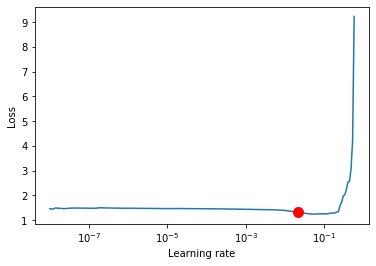

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


0.02089296130854041
Remember all accuracies are positive and defined to go towards 0 in the optimal case.


In [52]:
lr_finder = trainer.tuner.lr_find(model,train_loader,val_loader,max_lr=1,num_training=200,mode='exponential',early_stop_threshold=4)

fig = lr_finder.plot(True,True)
print(lr_finder.suggestion())

args['lr'] = lr_finder.suggestion()
Net = M.Load_model(args['type'],args)
model = Net()
trainer, wandb_logger = fc.return_trainer(path = path,
                                          run_name = run_name,
                                          args = args,)

In [80]:
wandb_logger.experiment.config.update(args)
# wandb_logger.watch(model)
wandb_logger.experiment.log({f'lr finder, lr={lr_finder.suggestion()}': wandb.Image(fig)})

wandb: Currently logged in as: vinther901 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [81]:
trainer.fit(model, train_loader, val_loader)


   | Name                | Type       | Params
----------------------------------------------------
0  | act                 | SiLU       | 0     
1  | x_encoder           | Linear     | 2.9 K 
2  | CoC_encoder         | Linear     | 11.5 K
3  | GRUCells            | ModuleList | 37.2 K
4  | lins_CoC_msg        | ModuleList | 16.4 K
5  | lins_CoC_self       | ModuleList | 4.2 K 
6  | CoC_batch_norm      | ModuleList | 128   
7  | lins_x_msg          | ModuleList | 4.2 K 
8  | lins_x_self         | ModuleList | 4.2 K 
9  | x_batch_norm        | ModuleList | 128   
10 | decoders            | ModuleList | 24.7 K
11 | decoder_batch_norms | ModuleList | 256   
12 | decoder             | Linear     | 260   
----------------------------------------------------
106 K     Trainable params
0         Non-trainable params
106 K     Total params
0.424     Total estimated model params size (MB)


C:\Users\jv97\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:50: UserWarning: Trying to log at a previous step. Use `WandbLogger(sync_step=False)` or try logging with `commit=False` when calling manually `wandb.log`.
  warnings.warn(*args, **kwargs)
wandb: WARNING Step must only increase in log calls.  Step 0 < 1; dropping {'lr-Adam': 0.001045}.


Epoch 0, global step 397: Val Acc reached 1.18663 (best 1.18663), saving model to "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\oscNext_angle_m9_2vr5\oscNext_angle_m9-epoch=0-Val Acc=1.187.ckpt" as top 1
C:\Users\jv97\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Epoch 1, global step 795: Val Acc reached 1.16074 (best 1.16074), saving model to "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\oscNext_angle_m9_2vr5\oscNext_angle_m9-epoch=1-Val Acc=1.161.ckpt" as top 1


Epoch 2, global step 1193: Val Acc reached 1.13631 (best 1.13631), saving model to "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\oscNext_angle_m9_2vr5\oscNext_angle_m9-epoch=2-Val Acc=1.136.ckpt" as top 1


Epoch 3, global step 1591: Val Acc reached 1.11234 (best 1.11234), saving model to "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\oscNext_angle_m9_2vr5\oscNext_angle_m9-epoch=3-Val Acc=1.112.ckpt" as top 1


Epoch 4, step 1989: Val Acc was not in top 1


Epoch 5, global step 2387: Val Acc reached 1.07197 (best 1.07197), saving model to "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\oscNext_angle_m9_2vr5\oscNext_angle_m9-epoch=5-Val Acc=1.072.ckpt" as top 1


Epoch 6, global step 2785: Val Acc reached 0.81293 (best 0.81293), saving model to "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\oscNext_angle_m9_2vr5\oscNext_angle_m9-epoch=6-Val Acc=0.813.ckpt" as top 1


Epoch 7, global step 3183: Val Acc reached 0.74850 (best 0.74850), saving model to "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\oscNext_angle_m9_2vr5\oscNext_angle_m9-epoch=7-Val Acc=0.748.ckpt" as top 1


Epoch 8, step 3581: Val Acc was not in top 1


Epoch 9, global step 3979: Val Acc reached 0.73296 (best 0.73296), saving model to "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\oscNext_angle_m9_2vr5\oscNext_angle_m9-epoch=9-Val Acc=0.733.ckpt" as top 1


Epoch 10, global step 4377: Val Acc reached 0.69533 (best 0.69533), saving model to "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\oscNext_angle_m9_2vr5\oscNext_angle_m9-epoch=10-Val Acc=0.695.ckpt" as top 1


Epoch 11, global step 4775: Val Acc reached 0.68224 (best 0.68224), saving model to "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\oscNext_angle_m9_2vr5\oscNext_angle_m9-epoch=11-Val Acc=0.682.ckpt" as top 1


Epoch 12, step 5173: Val Acc was not in top 1


Epoch 13, global step 5571: Val Acc reached 0.67777 (best 0.67777), saving model to "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\oscNext_angle_m9_2vr5\oscNext_angle_m9-epoch=13-Val Acc=0.678.ckpt" as top 1


Epoch 14, step 5969: Val Acc was not in top 1


Epoch 15, step 6367: Val Acc was not in top 1


Epoch 16, step 6765: Val Acc was not in top 1


Epoch 17, global step 7163: Val Acc reached 0.67419 (best 0.67419), saving model to "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\oscNext_angle_m9_2vr5\oscNext_angle_m9-epoch=17-Val Acc=0.674.ckpt" as top 1


Epoch 18, global step 7561: Val Acc reached 0.66757 (best 0.66757), saving model to "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\oscNext_angle_m9_2vr5\oscNext_angle_m9-epoch=18-Val Acc=0.668.ckpt" as top 1


Epoch 19, global step 7959: Val Acc reached 0.65866 (best 0.65866), saving model to "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\oscNext_angle_m9_2vr5\oscNext_angle_m9-epoch=19-Val Acc=0.659.ckpt" as top 1


Epoch 20, step 8357: Val Acc was not in top 1


Epoch 21, step 8755: Val Acc was not in top 1


Epoch 22, step 9153: Val Acc was not in top 1


Epoch 23, step 9551: Val Acc was not in top 1


Epoch 24, step 9949: Val Acc was not in top 1


Epoch 25, global step 10347: Val Acc reached 0.65555 (best 0.65555), saving model to "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\oscNext_angle_m9_2vr5\oscNext_angle_m9-epoch=25-Val Acc=0.656.ckpt" as top 1


Epoch 26, step 10745: Val Acc was not in top 1
C:\Users\jv97\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:50: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Epoch 27, step 10775: Val Acc was not in top 1


1

In [82]:
trainer.save_checkpoint(path + '/checkpoints/' + run_name + '_' + args['id'] + '/' + run_name + '_latest.ckpt')
print("potentially remember wandb.finish()")

potentially remember wandb.finish()


In [86]:
model = Net.load_from_checkpoint(path + '/checkpoints/' + run_name + '_' + args['id'] + '/' + run_name + '_latest.ckpt')

In [87]:
pred, truth = fc.return_reco_truth(model,val_loader)

Batch: 100%|███████████████████████████████████| 80/80 [01:19<00:00,  1.14it/s]

In [102]:
# pd.Series(dataset.val().event_nos,name='event_no').to_pickle(r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\oscNext_angle_m9_2vr5\val_event_nos.pkl')

0        105314908
1        114395327
2        117298442
3        102188838
4         30180837
           ...    
40652     51151307
40653     54156359
40654     75154484
40655     48105662
40656     78091584
Name: event_no, Length: 40657, dtype: int64

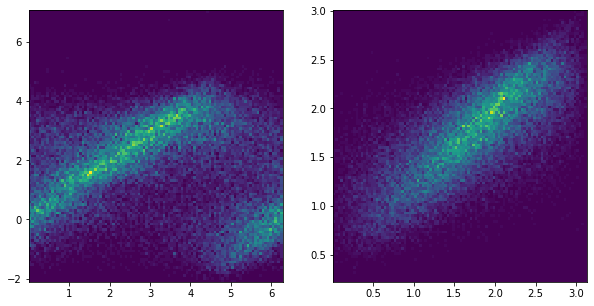

In [94]:
fig, ax = plt.subplots(figsize=(10,5),ncols=2)
ax[0].hist2d(truth[:,0],pred[:,0],bins=100);
ax[1].hist2d(truth[:,1],pred[:,1],bins=100);

In [103]:
wandb.finish()

_runtime,14458
_timestamp,1616003189
_step,10749
Train Loss,-0.33702
Train Acc,0.6416
epoch,27
Val Acc,0.65624
lr-Adam,0.00678


_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Train Loss,█▆▆▆▅▄▅▅▅▄▃▃▃▃▃▃▃▂▂▂▃▃▄▂▂▂▂▂▂▂▂▂▂▁▁▃▁▂▂▁
Train Acc,█▆▆▆▆▅▅▆▅▃▃▂▂▂▂▂▂▁▁▂▂▂▃▁▁▂▂▁▁▁▁▁▂▁▁▂▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
Val Acc,██▇▇▇▆▃▂▃▂▂▁▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁
lr-Adam,▁█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂
